# Raytracing Demo

In this notebook, we will see a minimal working example of FlowPM to run the Nbody and generate a Weak Lensing Mock Map



In [1]:
%pylab inline 
%load_ext autoreload
%autoreload 2
import tensorflow as tf
import numpy as np
from flowpm.tfpower import linear_matter_power
from flowpm.tfbackground import a_of_chi, rad_comoving_distance
import flowpm.raytracing as raytracing
from flowpm.cosmology import Planck15
import flowpm.constants as constants
import flowpm  
import flowpm.scipy.interpolate as interpolate
from itertools import cycle
from flowpm.fourier_smoothing import fourier_smoothing
import astropy.units as u
from flowpm.tfpm import make_ode_fn
import tensorflow_probability as tfp
import cmasher as cmr
import matplotlib.colors as colors


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


### Define key parameters of our Universe

In [2]:
nc=[128,128,128]   #Number of mesh-points along one axis, size of the cube. Then the number of particles will be N^3
Boxsize=[205,205,205] #Physical size of the Universe in Mpc/h
n_lens= 11

In [3]:
Omega_c= 0.2589
Omega_b=0.04860
sigma8= 0.8159
n_s= 0.9667
h= 0.6774
w0= -1.0

In [4]:
cosmology = flowpm.cosmology.Planck15()
r = tf.linspace(0., Boxsize[0] * n_lens, n_lens + 1)
a =flowpm.tfbackground.a_of_chi(cosmology, r)
r_center = 0.5 * (r[1:] + r[:-1])
a_center = flowpm.tfbackground.a_of_chi(cosmology, r_center)
stages = a_center[::-1]
batch_size=1   #Batch size, how many independent Universes to simulate

Text(0.5, 0, 'Mpc/h')

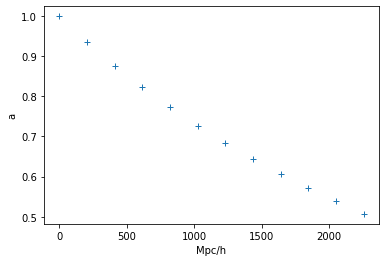

In [5]:
# This allows us to go to roughly z=1
plot(r,a, '+')
ylabel(r'a')
xlabel(r'Mpc/h')

#### Genereting the initial conditions 

In [6]:
a0=0.14285714254594556 #the initial epoch from where we begin the evolution, a0=0 corresponds to birth but is numerically unstable
k = tf.constant(np.logspace(-4, 1, 128), dtype=tf.float32)
pk = linear_matter_power(cosmology, k)
pk_fun = lambda x: tf.cast(
        tf.reshape(
            interpolate.interp_tf(tf.reshape(tf.cast(x, tf.float32), [-1]), k,
                                  pk), x.shape), tf.complex64)
initial_conditions = flowpm.linear_field(nc,    
                                            Boxsize, 
                                             pk_fun,         
                                             batch_size=1)
initial_state = flowpm.lpt_init(cosmology, initial_conditions,
                                    a0)
initial_state = initial_state[0:2]  



In [7]:
loaded=tf.saved_model.load("/local/home/dl264294/flowpm/saved_model")

In [8]:
import tensorflow as tf
import numpy as np
import flowpm
from flowpm.kernels import fftk, longrange_kernel, gradient_kernel, laplace_kernel
from flowpm.utils import cic_readout, compensate_cic, c2r3d, r2c3d
from flowpm.cosmology import Planck15


def make_neural_ode_fn(nc, batch_size):

  def neural_nbody_ode(a, state, Omega_c, sigma8, Omega_b, n_s, h, w0):
    """
      Estimate force on the particles given a state.
      Parameters:
      -----------
      nc: int
        Number of cells in the field.
      
      batch_size: int
        Size of batches
        
      params_filename: 
        PM correction parameters 
        
      a : array_like or tf.TensorArray
        Scale factor
        
      state: tensor
        Input state tensor of shape (2, batch_size, npart, 3)
      Omega_c, sigma8, Omega_b, n_s,h, w0 : Scalar float Tensor
        Cosmological parameters
      Returns
      -------
      dpos: tensor (batch_size, npart, 3)
        Updated position at a given state
      dvel: tensor (batch_size, npart, 3)
        Updated velocity at a given state
      """

    pos = state[0]
    vel = state[1]
    kvec = fftk([nc, nc, nc], symmetric=False)
    cosmo = flowpm.cosmology.Planck15(
        Omega_c=Omega_c, sigma8=sigma8, Omega_b=Omega_b, n_s=n_s, h=h, w0=w0)
    delta = flowpm.cic_paint(tf.zeros([batch_size, nc, nc, nc]), pos)
    delta_k = r2c3d(delta)

    # Computes gravitational potential
    lap = tf.cast(laplace_kernel(kvec), tf.complex64)
    fknlrange = longrange_kernel(kvec, r_split=0)
    kweight = lap * fknlrange
    pot_k = tf.multiply(delta_k, kweight)

    # Apply a correction filter
    kk = tf.math.sqrt(sum((ki / np.pi)**2 for ki in kvec))
    pot_k = pot_k * tf.cast(
        (1. + loaded.forward(tf.cast(kk, tf.float32), tf.cast(a, tf.float32))),
        tf.complex64)
    # Computes gravitational forces

    forces = tf.stack([
        flowpm.cic_readout(
            c2r3d(tf.multiply(pot_k, gradient_kernel(kvec, i))), pos)
        for i in range(3)
    ],
                      axis=-1)
    forces = forces * 1.5 * cosmo.Omega_m

    #Computes the update of position (drift)
    dpos = 1. / (a**3 * flowpm.tfbackground.E(cosmo, a)) * vel

    #Computes the update of velocity (kick)
    dvel = 1. / (a**2 * flowpm.tfbackground.E(cosmo, a)) * forces

    return tf.stack([dpos, dvel], axis=0)

  return neural_nbody_ode

#### Running the simulations

In [9]:

res = tfp.math.ode.DormandPrince(rtol=1e-5,
                                     atol=1e-5).solve( make_neural_ode_fn(nc[0], batch_size),0.14285714254594556,
                                                      initial_state,
                                                      solution_times=stages,
                                                      constants={
                                                          'Omega_c': Omega_c,
                                                          'sigma8': sigma8,
                                                          'Omega_b': Omega_b,
                                                          'n_s': n_s,
                                                          'h': h,
                                                          'w0': w0,
                                                      })

/tmp/ipykernel_757146/2907548329.py:55: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  kk = tf.math.sqrt(sum((ki / np.pi)**2 for ki in kvec))


#### Retrieve final density field

In [10]:
final_field = flowpm.cic_paint(tf.zeros_like(initial_conditions),res.states[::-1][0][0])[0]

#### And this is what remains of the simulation at redhift 0.034

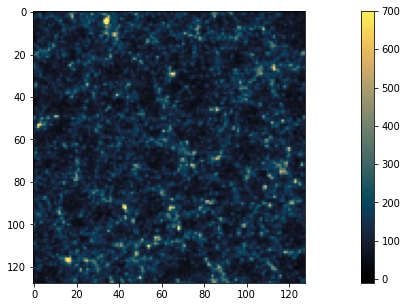

In [11]:

figure(figsize=[20,5])
imshow(final_field.numpy().sum(axis=0),cmap=cmr.eclipse,vmin=-10,vmax=700)
colorbar()

# Genereting the Ray-Traced Weak Lensing Mock Map


In [12]:
field_npix= 1024 
field_size=5.

#### Let's define the source's redshift

In [13]:
z_source=1
a_source=1/(1.0 + z_source)
d_source=rad_comoving_distance(cosmology,a_source)

#### Constructing the lightcone

In [14]:
lensplanes = []
matrix = flowpm.raytracing.rotation_matrices()
for i, j in zip(range(len(a_center)), cycle(range(6))):
    plane = flowpm.raytracing.density_plane(
        res.states[::-1][i],
        nc,
        nc[0] // 2,
        width=nc[0],
        plane_resolution=2048,
        rotation=matrix[j],
        shift=flowpm.raytracing.random_2d_shift(),
    )

    plane = fourier_smoothing(plane, sigma=1.024, resolution=2048)
    lensplanes.append((r_center[i], res.times[::-1][i], plane))
xgrid, ygrid = np.meshgrid(
    np.linspace(0, field_size, field_npix,
                endpoint=False),  # range of X coordinates
    np.linspace(0, field_size, field_npix,
                endpoint=False))  # range of Y coordinates

coords = np.stack([xgrid, ygrid], axis=0)
c = coords.reshape([2, -1]).T / 180. * np.pi  # convert to rad from deg
m = flowpm.raytracing.convergenceBorn(cosmology,
                                      lensplanes,
                                      dx=Boxsize[0] / 2048,
                                      dz=Boxsize[0],
                                      coords=c,
                                      z_source=z_source,
                                      field_npix=field_npix)

#### Here are the lens planes exported during the simulation

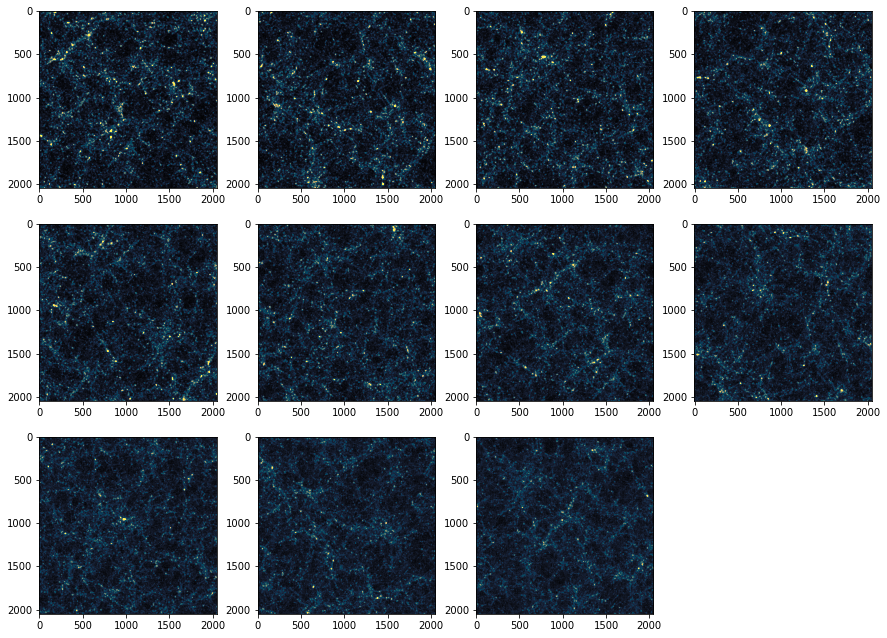

In [15]:

figure(figsize=[15,15])
for i in range(len(lensplanes)):
    subplot(4,4,i+1)
    imshow(lensplanes[i][-1][0],cmap=cmr.eclipse,vmin=0,vmax=6)
    

#### Here the final convergence map

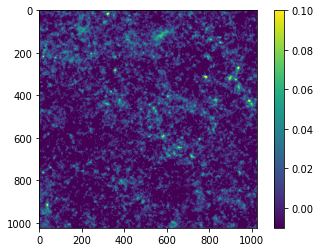

In [16]:
imshow(m[0],cmap='viridis',vmin=-0.01, vmax=0.1); 
colorbar()